In [ ]:
DATASET_PATH="/home/ll16598/Documents/INNOVATE"
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import ruptures as rpt
import warnings
import ruptures
import requests
import time
import networkx as nx
warnings.filterwarnings('ignore')


In [ ]:
df=pd.read_csv('./Data/Derivative_Datasets/jump_data.csv')
paper_titles = df['paper_title'].tolist()

In [ ]:
def get_paper_data(title):
    params = {
        'query.title': title,
        'rows': 1,
        'select': 'DOI,title,author,reference'
    }
    try:
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            result = response.json()
            if 'message' in result and 'items' in result['message'] and len(result['message']['items']) > 0:
                paper = result['message']['items'][0]
                references = paper.get('reference', [])  # Handle missing references
                print(f"Found {len(references)} references for {title}")
                return paper  # Return the full paper data, including references
            else:
                print(f"No results found for {title}")
                return None
        else:
            print(f"Error fetching data for {title}: {response.status_code}")
            return None
    except Exception as e:
        print(f"Exception occurred for {title}: {e}")
        return None


In [ ]:
def get_g(paper):
    graph = nx.DiGraph()
    try:
        paper_doi = paper['DOI']
    except Exception as e:
        paer_doi='missing'
    try:
        paper_title = paper['title']
    except Exception as e:
        return graph
    jump= df['jump'].loc[idx]
    graph.add_node(paper_title[0], jump=jump,title=paper_title, doi=paper_doi)
    references = paper.get('reference', [])
    for ref in references:
        ref_doi = ref.get('DOI', None)
        ref_title = ref.get('article-title', None)

        if ref_title:
            # Add an edge from the current paper to the reference
            graph.add_node(ref_title, doi=ref_doi,  title=ref_title)  # Add reference as a node
            graph.add_edge(ref_title, paper_title[0])  # Add directed edge from paper to reference
        elif ref_doi:
            # Add an edge from the current paper to the reference
            graph.add_node(ref_doi, doi=ref_doi, title=ref_title)  # Add reference as a node
            graph.add_edge(ref_doi, paper_title[0])  # Add directed edge from paper to reference
    return graph

In [ ]:
save_dir_gs='/media/ll16598/One Touch/INNOVATE/base_graphs/'

In [ ]:
import hashlib
def convert_attributes_to_string(graph):
    # Convert node attributes
    for node, data in graph.nodes(data=True):
        updated_data = {k: str(v) if isinstance(v, (list, dict)) else v for k, v in data.items()}
        nx.set_node_attributes(graph, {node: updated_data})

    # Convert edge attributes
    for u, v, data in graph.edges(data=True):
        updated_data = {k: str(v) if isinstance(v, (list, dict)) else v for k, v in data.items()}
        nx.set_edge_attributes(graph, {(u, v): updated_data})

    return graph
def generate_node_id(title):
    return hashlib.md5(title.encode()).hexdigest()

# Modify graph to use hashed node identifiers
def simplify_node_ids(graph):
    mapping = {node: generate_node_id(node) for node in graph.nodes()}
    return nx.relabel_nodes(graph, mapping)

In [ ]:
import os
g_list=sorted(os.listdir(save_dir_gs))

In [ ]:
save_dir_gs_combo='/media/ll16598/One Touch/INNOVATE/combo_graphs/'

In [ ]:
g_list_combo=sorted(os.listdir(save_dir_gs_combo))

In [ ]:
all_datas=[]
unique_dataset_task_combinations = df[['dataset', 'task','metrics']].drop_duplicates()
s=0

# Loop through each unique dataset-task combination and create a plot
for _, row in unique_dataset_task_combinations.iterrows():
    dataset = row['dataset']
    task = row['task']
    metrics = row['metrics']
    # Filter the DataFrame for the current dataset-task combination
    task_data = df[(df['dataset'] == dataset) & (df['task'] == task)& (df['metrics'] == metrics)]
    task_data=task_data.reset_index(drop=True)
    task_data['DOI']

    task_data['combined_graph']=None
    k=0
    for r, el in enumerate(task_data['edgelist']):
        g=nx.read_edgelist(g,save_dir_gs+f'{idx}_base.edgelist')
        if s<len(g_list_combo):
            continue
        if k==0:
            task_data['combined_graph'].loc[s]=nx.to_edgelist(g)
            nx.write_edgelist(g,save_dir_gs_combo+f'{idx}_first.edgelist')
            k+=1
            s+=1
            continue
        else:
            combo_g=nx.compose(nx.from_edgelist(task_data['edgelist'].loc[r]),\
                               nx.from_edgelist(task_data['edgelist'].loc[r-1]))
            task_data['combined_graph'].loc[r]=nx.to_edgelist(combo_g)
            nx.write_edgelist(g,save_dir_gs_combo+f'{idx}_combo.edgelist')

            k+=1
            s+=1
    all_datas.append(task_data)

In [10]:
total_dat=pd.concat(all_datas).reset_index(drop=True)
total_dat.to_csv('./Data/Derivative_Datasets/jump_data_combo_edgelists.csv')

NameError: name 'all_datas' is not defined

#######BELOW IS EXTRA

In [146]:
df['graph']=None
df=df.reset_index(drop=True)
for idx, p in enumerate(df['papers_data']):
    graph = nx.DiGraph()
    #paper=json.loads(p)
    paper=p
    paper_doi = paper['DOI']
    paper_title = paper['title']
    jump= df['jump'].loc[idx]
    # Add the paper itself as a node
    graph.add_node(paper_title[0], jump=jump,title=paper_title, doi=paper_doi)

    # Add references (edges from the paper to its references)
    references = paper.get('reference', [])
    print(len(references))
    for ref in references:
        ref_doi = ref.get('DOI', None)
        ref_title = ref.get('article-title', None)

        if ref_title:
            # Add an edge from the current paper to the reference
            graph.add_node(ref_title, doi=ref_doi,  title=ref_title)  # Add reference as a node
            graph.add_edge(ref_title, paper_title[0])  # Add directed edge from paper to reference
        elif ref_doi:
            # Add an edge from the current paper to the reference
            graph.add_node(ref_doi, doi=ref_doi, title=ref_title)  # Add reference as a node
            graph.add_edge(ref_doi, paper_title[0])  # Add directed edge from paper to reference
        
    df['graph'].loc[idx] =graph

57
45
60
48
21
68
18
59
35
43
49
0
109
0
67
115
77
38
109
0
67
115
77
38
109
0
67
115
77
38
109
0
67
115
77
38
55
109
0
67
115
77
38
41
55
44


TypeError: 'NoneType' object is not subscriptable

Now I need to check for all of the nodes in the graph to see if they jump on the same or different graph

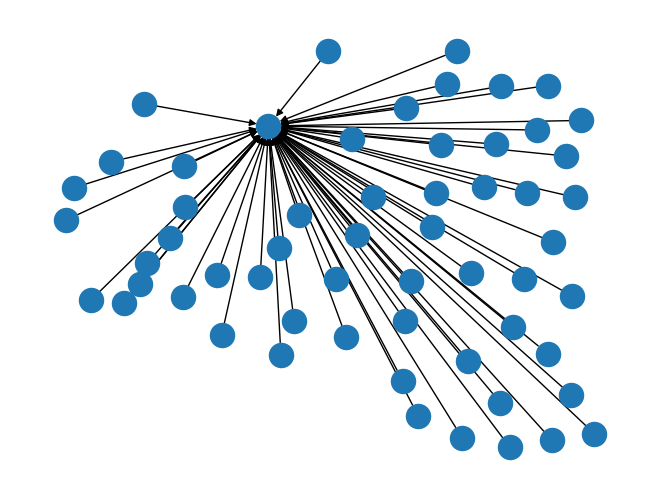

In [150]:
nx.draw(df['graph'][0])

AttributeError: 'NoneType' object has no attribute 'graph'

In [153]:
import networkx as nx

# Example: Assuming task_data['combined_graph'] contains graph objects
for i in range(1, len(task_data['combined_graph'])):
    current_graph = task_data['combined_graph'].iloc[i]
    previous_graph = task_data['combined_graph'].iloc[i - 1]

    # Get the set of nodes in the current and previous graph
    current_nodes = set(current_graph.nodes())
    previous_nodes = set(previous_graph.nodes())

    # Calculate the number of nodes in the current graph that are also in the previous graph
    common_nodes = current_nodes.intersection(previous_nodes)
    
    # Calculate the proportion of nodes in the current graph that are in the previous graph
    if len(current_nodes) > 0:
        proportion = len(common_nodes) / len(current_nodes)
    else:
        proportion = 0  # Handle the case where the current graph has no nodes
    
    # Print the result for the current graph
    print(f"Proportion of nodes in graph {i} that were in the previous graph: {proportion:.2f}")


Proportion of nodes in graph 1 that were in the previous graph: 0.44
Proportion of nodes in graph 2 that were in the previous graph: 0.55


AttributeError: 'NoneType' object has no attribute 'nodes'

In [154]:
all_datas[1]

,Unnamed: 0.1,Unnamed: 0,paper_title,paper_date,task,parent_task,dataset,score,benchmark_id,metrics,task_categories,abstract,repo_url,CV,NLP,jump,graph,papers_data,DOI,combined_graph
0,6,19.0,Active Learning for Convolutional Neural Netwo...,2017-08-01,Active Learning,Optical Character Recognition (OCR),"CIFAR10 (10,000)",0.309474,1111.0,Accuracy,"Natural Language Processing,Methodology,Comput...",Convolutional neural networks (CNNs) have been...,https://github.com/webis-de/small-text,False,False,0.0,(Active Learning Strategies and Convolutional ...,DOI 10.1007/978-...,None,(Active Learning Strategies and Convolutional ...
1,7,17.0,Learning Loss for Active Learning,2019-05-09,Active Learning,Optical Character Recognition (OCR),"CIFAR10 (10,000)",0.538947,1111.0,Accuracy,"Natural Language Processing,Methodology,Comput...",The performance of deep neural networks improv...,https://github.com/seominseok0429/Learning-Los...,False,False,0.0,"(Learning Loss for Active Learning, 10.1109/IC...",DOI 10.1109...,None,"(Learning Loss for Active Learning, 10.1109/IC..."
2,8,20.0,Towards Robust and Reproducible Active Learnin...,2020-02-21,Active Learning,Optical Character Recognition (OCR),"CIFAR10 (10,000)",0.000000,1111.0,Accuracy,"Natural Language Processing,Methodology,Comput...",Active learning (AL) is a promising ML paradig...,https://github.com/prateekmunjal/torchal,False,False,2.0,(Towards Robust and Reproducible Active Learni...,DOI 10.1109/cvpr...,None,(Towards Robust and Reproducible Active Learni...
3,9,18.0,Sequential Graph Convolutional Network for Act...,2020-06-18,Active Learning,Optical Character Recognition (OCR),"CIFAR10 (10,000)",0.473684,1111.0,Accuracy,"Natural Language Processing,Methodology,Comput...",We propose a novel pool-based Active Learning ...,https://github.com/razvancaramalau/Sequential-...,False,False,2.0,(Sequential Graph Convolutional Network for Ac...,DOI 10.1109/cvpr...,None,(Sequential Graph Convolutional Network for Ac...
4,10,16.0,PT4AL: Using Self-Supervised Pretext Tasks for...,2022-01-19,Active Learning,Optical Character Recognition (OCR),"CIFAR10 (10,000)",0.978947,1111.0,Accuracy,"Natural Language Processing,Methodology,Comput...",Labeling a large set of data is expensive. Act...,https://github.com/johnsk95/pt4al,False,False,0.0,(PT4AL: Using Self-supervised Pretext Tasks fo...,DOI 10.1007/978-...,None,(PT4AL: Using Self-supervised Pretext Tasks fo...
5,11,15.0,Active Learning on a Budget: Opposite Strategi...,2022-02-06,Active Learning,Optical Character Recognition (OCR),"CIFAR10 (10,000)",1.000000,1111.0,Accuracy,"Natural Language Processing,Methodology,Comput...","Investigating active learning, we focus on the...",https://github.com/avihu111/typiclust,False,False,0.0,(Budgets: A Suit to Watch),DOI 10....,None,"(Budgets: A Suit to Watch, PT4AL: Using Self-s..."


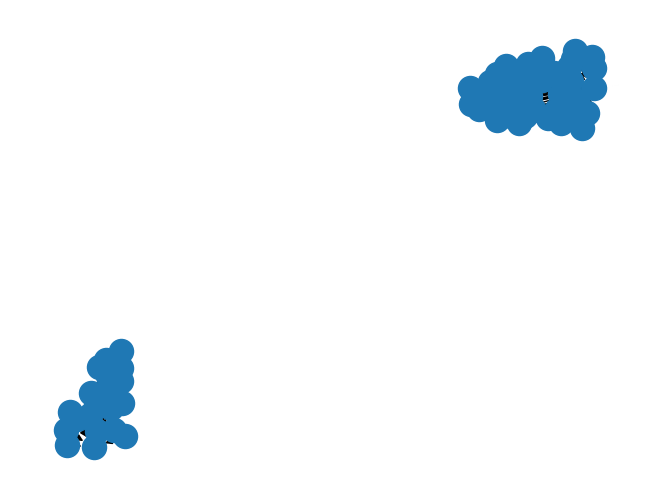

In [158]:
nx.draw(all_datas[0]['combined_graph'][3])


In [137]:
nx.draw(task_data['combined_graph'][2])


KeyError: 2

In [92]:
len(df['graph'][0].nodes(data=True))

58

In [73]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'paper_title', 'paper_date', 'task',
       'parent_task', 'dataset', 'score', 'benchmark_id', 'metrics',
       'task_categories', 'abstract', 'repo_url', 'CV', 'NLP', 'jump',
       'graph'],
      dtype='object')

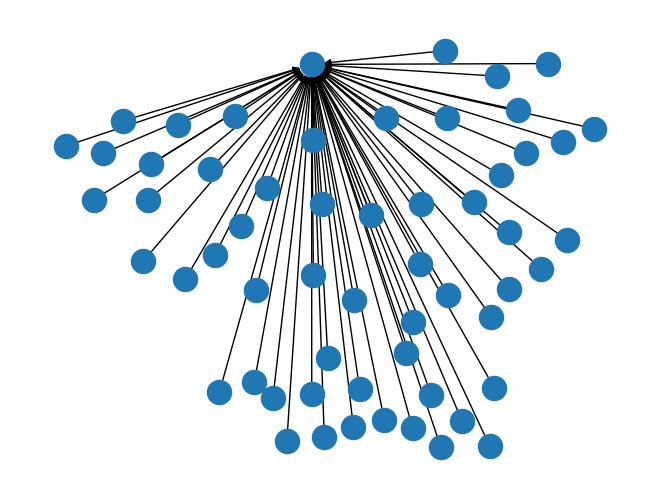

In [72]:
nx.draw(df['graph'][0])

THis does overall:


In [ ]:
df['graph']=None
for idx, p in enumerate(df['papers_data']):
    graph = nx.DiGraph()
    #paper=json.loads(p)
    paper=p
    paper_doi = paper['DOI']
    paper_title = paper['title']
    jump= df['jump'].loc[idx]
    # Add the paper itself as a node
    graph.add_node(paper_title[0], jump=jump,title=paper_title, doi=paper_doi)

    # Add references (edges from the paper to its references)
    references = paper.get('reference', [])
    print(len(references))
    for ref in references:
        ref_doi = ref.get('DOI', None)
        ref_title = ref.get('article-title', None)

        if ref_title:
            # Add an edge from the current paper to the reference
            graph.add_node(ref_title, doi=ref_doi,  title=ref_title)  # Add reference as a node
            graph.add_edge(ref_title, paper_title[0])  # Add directed edge from paper to reference
        elif ref_doi:
            # Add an edge from the current paper to the reference
            graph.add_node(ref_doi, doi=ref_doi, title=ref_title)  # Add reference as a node
            graph.add_edge(ref_doi, paper_title[0])  # Add directed edge from paper to reference
        
    df['graph'].loc[idx] =graph

In [13]:
graph = nx.DiGraph()

for p in papers_data:
    paper=json.loads(p)
    paper_doi = paper['DOI']
    paper_title = paper['title']

    # Add the paper itself as a node
    graph.add_node(paper_doi, title=paper_title)

    # Add references (edges from the paper to its references)
    references = paper.get('reference', [])
    for ref in references:
        ref_doi = ref.get('DOI', None)
        ref_title = ref.get('article-title', None)
        if ref_doi:
            # Add an edge from the current paper to the reference
            graph.add_node(ref_doi, title=ref_title)  # Add reference as a node
            graph.add_edge(paper_doi, ref_doi)  # Add directed edge from paper to reference


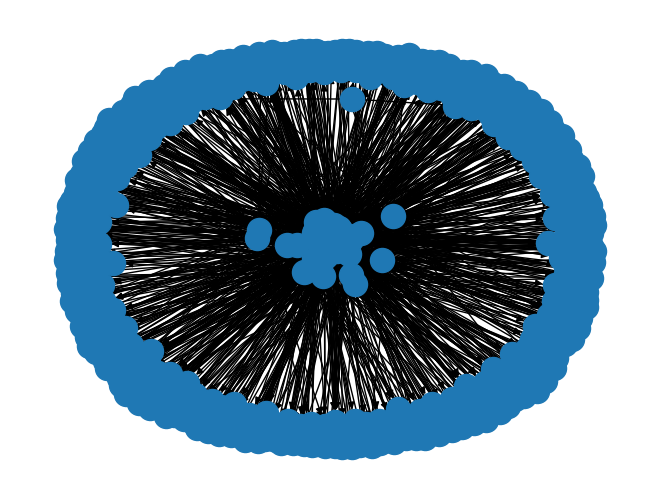

In [19]:
pos=nx.spring_layout(graph)
nx.draw(graph, pos=pos)

In [9]:
G = nx.DiGraph()
# Add papers data to the citation network
add_papers_to_network(papers_data, G)

# Now, G is a directed graph representing the citation network
# You can display information about the network, such as nodes and edges
network_info = {
    "nodes": list(G.nodes(data=True)),  # List of nodes with their data (like title)
    "edges": list(G.edges)  # List of edges representing citations
}

# Output network information for review
network_info

TypeError: string indices must be integers